In [48]:
# Dependencies and Setup
import os
import shutil
from zipfile import ZipFile

import matplotlib.pyplot as plt
import matplotlib

from bubbly.bubbly import bubbleplot
import squarify
import numpy as np
import pandas as pd

import pandas as pd
import requests
import seaborn as sns
import scipy.stats as st
from scipy.stats import linregress
from pathlib import Path

In [49]:
verbose = False

In [50]:
# The BLS files have all the county employment / wage info for our selected years and
# counties.

# Do not need anymore, keeping in case we missed something.
# nys_industycounty_path = "housing_data/NYS_Industry_by_County.csv"

# Study parameters

# Years 2012 - 2022
years = [ 2018,  # Before pandemic lockdown
         2019, 2020, 2021, 2022]  # During and after pandemic lockdown

# All NYC Boroughs and geographically adjacent counties
counties = [
    # NYC Boroughs
    "Bronx County, New York",
    "Kings County, New York",  # Brooklyn
    "New York County, New York",  # Manhattan
    "Queens County, New York",
    "Richmond County, New York",  # Staten Island

    # Counties adjacent to NYC Boroughs
    "Bergen County, New Jersey",
    "Nassau County, New York",
    "Hudson County, New Jersey",
    "Westchester County, New York",
    "Rockland County, New York",
    "Fairfield County, Connecticut",
]

In [51]:
# Download and/or extract BLS datasets from BLS site or file system (if pre-downloaded)
bls_csv_dir = "jobs_data"
bls_csv_files = {}
for year in years:
    zip_fn = f"{year}_qtrly_by_area.zip"
    zip_url = f"https://data.bls.gov/cew/data/files/{year}/csv/{zip_fn}"
    zip_path = f"{bls_csv_dir}/{zip_fn}"

    # Download the zip archive with the data for each year if it's not in the file system.
    if not os.path.isfile(zip_path):
        head_response = requests.head(zip_url)
        file_size = float(head_response.headers['Content-Length'])
        if file_size >= 2**30:
            file_size, units = file_size / 2**30, 'GiB'
        elif file_size >= 2**20:
            file_size, units = file_size / 2**20, 'MiB'
        elif file_size >= 2**10:
            file_size, units = file_size / 2**10, 'kiB'
        else:
            units = 'B'
        file_size = f"{file_size:03.2f} {units}"
        
        print(f"Downloading {zip_url!r} to {zip_path!r} for year {year}.")
        print(f"Expected size: {file_size}")
        get_response = requests.get(zip_url)
        with open(zip_path, 'wb') as zip_file:
            zip_file.write(get_response.content)

    # Find the csv for each county within the archive
    # print(f"Listing files in {zip_path!r} zip archive.")
    with ZipFile(zip_path) as zip_archive:
        files = zip_archive.namelist()
        for file in files:
            for county in counties:
                if file.endswith(f'{county}.csv'):
                    # print(f"{file=!r}")
                    csv_key = (year, county)
                    csv_dir, csv_fn = os.path.split(file)
                    csv_path = os.path.join(bls_csv_dir, csv_fn)
                    # print(f"{csv_fn=!r}")
                    bls_csv_files[csv_key] = csv_path
                    zip_archive.extract(file, bls_csv_dir)
                    shutil.move(f"{bls_csv_dir}/{file}", csv_path)
                    shutil.rmtree(f"{bls_csv_dir}/{csv_dir}")
if verbose:
    for key, path in bls_csv_files.items():
        year, county = key
        print(f"BLS employment / wage info csv for {year=} and {county=!r}: {path=!r}")
print(f"Found {len(bls_csv_files)} BLS employment / wage info csv files (expected {len(counties) * len(years)}).")

Found 55 BLS employment / wage info csv files (expected 55).


In [52]:
#Make sure that files are unzipped from Finder (stores files). Remove the ".zip" from the file name. Then it should recongize and read the file.
os.listdir(bls_csv_dir)

['2022.q1-q4 36087 Rockland County, New York.csv',
 '2020.q1-q4 36047 Kings County, New York.csv',
 '2019.q1-q4 36119 Westchester County, New York.csv',
 '2018.q1-q4 36061 New York County, New York.csv',
 '2022.q1-q4 36005 Bronx County, New York.csv',
 '2020.q1-q4 34003 Bergen County, New Jersey.csv',
 '.DS_Store',
 '2021.q1-q4 36061 New York County, New York.csv',
 '2019.q1-q4 34003 Bergen County, New Jersey.csv',
 '2020.q1-q4 36061 New York County, New York.csv',
 '2018.q1-q4 34003 Bergen County, New Jersey.csv',
 '2021.q1-q4 36005 Bronx County, New York.csv',
 '2019.q1-q4 36061 New York County, New York.csv',
 '2021.q1-q4 34003 Bergen County, New Jersey.csv',
 '2019.q1-q4 36085 Richmond County, New York.csv',
 '2018.q1-q4 36081 Queens County, New York.csv',
 '2020.q1-q4 36085 Richmond County, New York.csv',
 '2021.q1-q4 36085 Richmond County, New York.csv',
 '2021.q1-q4 36119 Westchester County, New York.csv',
 '2019.q1-q4 36081 Queens County, New York.csv',
 '2022.q1-q4 36081 Queen

In [53]:
printed_example = False
dfs = []  # Intentionallt plural
for key, path in bls_csv_files.items():
    year, county = key
    df = pd.read_csv(Path(path))  # Intentionally singular
    df["Year"] = year
    df["County"] = county
    # if not printed_example:
    #     print(df.head())
    #     printed_example = True
    dfs.append(df)

In [54]:
#Replace = rename. Can use the following code in this cell to rename individual column names.
# Clean up quarter category. Replace 'qtr' with 'Quarter'#"qtr":"Quarter" ##Data Cleaning
#clean_df['qtr'] = clean_df['qtr'].replace({'Quarter'})
#clean_df['Quarter'}.value_counts #Verifies the data cleaning
#The cell below is used to rename multiple columns at once.

In [55]:
#Reference: https://www.bls.gov/cew/about-data/downloadable-file-layouts/annual/naics-based-annual-layout.htm put a text cell to explain variables

In [59]:
merged_df = pd.concat(dfs)[["Year", "County", "qtr","agglvl_code", "agglvl_title","area_fips","area_title",
                            "avg_wkly_wage","industry_code","industry_title","lq_avg_wkly_wage","lq_month1_emplvl",
                            "lq_month2_emplvl","lq_month3_emplvl","lq_qtrly_contributions","lq_qtrly_estabs_count",
                            "lq_total_qtrly_wages","month1_emplvl","month2_emplvl", "month3_emplvl","oty_avg_wkly_wage_chg",
                            "oty_avg_wkly_wage_pct_chg","oty_month1_emplvl_chg",
                            "oty_month1_emplvl_pct_chg","oty_month2_emplvl_chg","oty_month2_emplvl_pct_chg",
                            "oty_month3_emplvl_chg","oty_month3_emplvl_pct_chg","oty_qtrly_contributions_chg",
                            "oty_qtrly_contributions_pct_chg","oty_qtrly_estabs_count_chg", "oty_qtrly_estabs_count_pct_chg",
                            "oty_total_qtrly_wages_chg","oty_total_qtrly_wages_pct_chg",
                            "own_code","own_title","qtr","qtrly_contributions","qtrly_estabs_count","size_code","size_title",
                            "total_qtrly_wages","year",
                           ]]  # Select which olumns to keep
merged_df = merged_df.rename(columns={  # Rename columns for readability and brevity
    "County":"County",
    "Year":"Year",
    "agglvl_code":"Aggreg_Code",
    "agglvl_title":"Aggreg_Title",
    "area_fips":"Area_Fips",
    "area_title":"Area_Title",
    "avg_wkly_wage":"Avg_Wk_Wage",
    "industry_code":"Industry_Code",
    "industry_title":"Industry_Title",
    "lq_avg_wkly_wage":"Loc_Avg_Wk_Employ",
    "lq_month1_emplvl":"Loc_Mon1_Employ",
    "lq_month2_emplvl":"Loc_Mon2_Employ",
    "lq_month3_emplvl":"Loc_Mon3_Employ",
    "lq_qtrly_contributions":"Loc_Quart_Cont",
    "lq_qtrly_estabs_count":"Loc_Quart_Est_Ct",
    "lq_total_qtrly_wages":"Loc_Tot_Quart_Wages",
    "month1_emplvl":"Mon1_Employ",
    "month2_emplvl":"Mon2_Employ",
    "month3_emplvl":"Mon3_Employ",
    "oty_month1_emplvl_chg":"Endyr_Mon1_Employ_Chg",
    "oty_month1_emplvl_pct_chg":"Endyr_Mon1_Employ_PctChg",
    "oty_month2_emplvl_chg":"Endyr_Mon2_Employ_Chg",
    "oty_month2_emplvl_pct_chg":"Endyr_Mon2_Employ_PctChg",
    "oty_month3_emplvl_chg":"Endyr_Mon3_Employ_Chg",
    "oty_month3_emplvl_pct_chg":"Endyr_Mon3_Employ_PctChg",
    "oty_qtrly_contributions_chg":"Endyr_Quart_Cont_Chg",
    "oty_qtrly_contributions_pct":"Endyr_Quart_Con_Pct",
    "oty_qtrly_contributions_pct_chg":"Endyr_Quart_Cont_PctChg",
    "oty_qtrly_estabs_count_chg":"Endyr_Est_Ct_Chg",
    "oty_qtrly_estabs_count_pct_chg":"Endyr_Est_Ct_PctChg",
    "oty_total_qtrly_wages_chg":"Endyr_Total_Quart_Wages_Chg",
    "own_code":"Own_Code",
    "own_title":"Own_Title",
    "qtr":"Quarter",
    "qtrly_contributions":"Quarter_Cont",
    "qtrly_estabs_count":"Quart_Est_Ct",
    "size_code":"Size_Code",
    "size_title":"Size_Title",
    "total_qtrly_wages":"Total_Quart_Wages",
    "year":"year"
})
merged_df['tmp'] = merged_df["Quarter"].values[:,1]
merged_df.drop(columns=['Quarter'], inplace=True)
merged_df.rename(columns={'tmp':'Quarter'}, inplace=True)
clean_df = merged_df[merged_df["Quarter"].isin([1,2,3,4])]  # Example filter; replace as needed.
clean_df.head(5)

,Year,County,Aggreg_Code,Aggreg_Title,Area_Fips,Area_Title,Avg_Wk_Wage,Industry_Code,Industry_Title,Loc_Avg_Wk_Employ,...,oty_total_qtrly_wages_pct_chg,Own_Code,Own_Title,Quarter_Cont,Quart_Est_Ct,Size_Code,Size_Title,Total_Quart_Wages,year,Quarter
0,2018,"Fairfield County, Connecticut",70,"County, Total Covered",9001,"Fairfield County, Connecticut",1983,10,"10 Total, all industries",1.0,...,3.0,0,Total Covered,116008402,35655,0,All establishment sizes,10673100494,2018,1
1,2018,"Fairfield County, Connecticut",70,"County, Total Covered",9001,"Fairfield County, Connecticut",1488,10,"10 Total, all industries",1.0,...,-0.9,0,Total Covered,36934444,35872,0,All establishment sizes,8184696534,2018,2
2,2018,"Fairfield County, Connecticut",70,"County, Total Covered",9001,"Fairfield County, Connecticut",1461,10,"10 Total, all industries",1.0,...,2.6,0,Total Covered,22569035,36092,0,All establishment sizes,7984915347,2018,3
3,2018,"Fairfield County, Connecticut",70,"County, Total Covered",9001,"Fairfield County, Connecticut",1705,10,"10 Total, all industries",1.0,...,1.4,0,Total Covered,17709906,36391,0,All establishment sizes,9426236666,2018,4
4,2018,"Fairfield County, Connecticut",71,"County, Total -- by ownership sector",9001,"Fairfield County, Connecticut",1335,10,"10 Total, all industries",0.5,...,3.2,1,Federal Government,0,81,0,All establishment sizes,48915570,2018,1


In [104]:
clean_df.columns

Index(['Year', 'County', 'Aggreg_Code', 'Aggreg_Title', 'Area_Fips',
       'Area_Title', 'Avg_Wk_Wage', 'Industry_Code', 'Industry_Title',
       'Loc_Avg_Wk_Employ', 'Loc_Mon1_Employ', 'Loc_Mon2_Employ',
       'Loc_Mon3_Employ', 'Loc_Quart_Cont', 'Loc_Quart_Est_Ct',
       'Loc_Tot_Quart_Wages', 'Mon1_Employ', 'Mon2_Employ', 'Mon3_Employ',
       'oty_avg_wkly_wage_chg', 'oty_avg_wkly_wage_pct_chg',
       'Endyr_Mon1_Employ_Chg', 'Endyr_Mon1_Employ_PctChg',
       'Endyr_Mon2_Employ_Chg', 'Endyr_Mon2_Employ_PctChg',
       'Endyr_Mon3_Employ_Chg', 'Endyr_Mon3_Employ_PctChg',
       'Endyr_Quart_Cont_Chg', 'Endyr_Quart_Cont_PctChg', 'Endyr_Est_Ct_Chg',
       'Endyr_Est_Ct_PctChg', 'Endyr_Total_Quart_Wages_Chg',
       'oty_total_qtrly_wages_pct_chg', 'Own_Code', 'Own_Title',
       'Quarter_Cont', 'Quart_Est_Ct', 'Size_Code', 'Size_Title',
       'Total_Quart_Wages', 'year', 'Quarter'],
      dtype='object')

In [ ]:
#Columns

#County: The name of the county.
# Year: The year the data pertains to.
#agglvl_code: Aggregation level code, indicating the level of data aggregation (e.g., state, county, industry).
#agglvl_title: Title or description of the aggregation level.
#area_fips: Federal Information Processing Standards (FIPS) code for the area.
#area_title: Name or title of the area.
#avg_wkly_wage: Average weekly wage.
#disclosure_code: Code indicating if data is withheld or disclosed for privacy reasons.
#industry_code: Code representing the industry.
#industry_title: Title or name of the industry.
#lq_avg_wkly_wage: Location quotient of the average weekly wage, comparing local industry wages to national industry wages.
#lq_disclosure_code: Location quotient disclosure code.
#lq_month1_emplvl: Employment level for the first month in the location quotient context.
#lq_month2_emplvl: Employment level for the second month in the location quotient context.
#lq_month3_emplvl: Employment level for the third month in the location quotient context.
#lq_qtrly_contributions: Quarterly contributions in the location quotient context.
#lq_qtrly_estabs_count: Quarterly establishment count in the location quotient context.
#lq_taxable_qtrly_wages: Taxable quarterly wages in the location quotient context.
#month1_emplvl: Employment level for the first month.
#month2_emplvl: Employment level for the second month.
#month3_emplvl: Employment level for the third month.
#oty_avg_wkly_wage_chg: Over-the-year change in average weekly wage.
#oty_avg_wkly_wage_pct: Over-the-year percentage of the average weekly wage.
#oty_avg_wkly_wage_pct_chg: Over-the-year percentage change in average weekly wage.
#oty_month1_emplvl_chg: Over-the-year change in employment level for the first month.
#oty_month1_emplvl_pct: Over-the-year percentage of employment level for the first month.
#oty_month1_emplvl_pct_chg: Over-the-year percentage change in employment level for the first month.
#oty_month2_emplvl_chg: Over-the-year change in employment level for the second month.
#oty_month2_emplvl_pct: Over-the-year percentage of employment level for the second month.
#oty_month2_emplvl_pct_chg: Over-the-year percentage change in employment level for the second month.
#oty_month3_emplvl_chg: Over-the-year change in employment level for the third month.
#oty_month3_emplvl_pct: Over-the-year percentage of employment level for the third month.
#oty_month3_emplvl_pct_chg: Over-the-year percentage change in employment level for the third month.
#oty_qtrly_contributions_chg: Over-the-year change in quarterly contributions.
#oty_qtrly_contributions_pct: Over-the-year percentage of quarterly contributions.
#oty_qtrly_contributions_pct_chg: Over-the-year percentage change in quarterly contributions.
#oty_qtrly_estabs_count_chg: Over-the-year change in quarterly establishment count.
#oty_qtrly_estabs_count_pct_chg: Over-the-year percentage change in quarterly establishment count.
#oty_taxable_qtrly_wages_chg: Over-the-year change in taxable quarterly wages.
#oty_taxable_qtrly_wages_chg.1: Duplicate or additional field for over-the-year change in taxable quarterly wages.
#oty_taxable_qtrly_wages_pct_chg: Over-the-year percentage change in taxable quarterly wages.
#oty_total_qtrly_wages_chg: Over-the-year change in total quarterly wages.
#oty_total_qtrly_wages_pct: Over-the-year percentage of total quarterly wages.
#oty_total_qtrly_wages_pct_chg: Over-the-year percentage change in total quarterly wages.
#own_code: Ownership code, indicating the type of ownership (e.g., private, government).
#own_title: Title or description of the ownership type.
#qtr: Quarter of the year.
#qtrly_contributions: Quarterly contributions.
#qtrly_estabs_count: Quarterly establishment count.
#size_code: Size code, indicating the size category of establishments.
#size_title: Title or description of the size category.
#taxable_qtrly_wages: Taxable quarterly wages.
#total_qtrly_wages: Total quarterly wages.
#year: Year the data pertains to (appears to be a duplicate of column 2)

In [ ]:
#Renamed Columns

    #"County":"County",
    #"Year":"Year",
    #"agglvl_code":"Aggreg_Code",
    #"agglvl_title":"Aggreg_Title",
    #"area_fips":"Area_Fips",
    #"area_title":"Area_Title",
    #"avg_wkly_wage":"Avg_Wk_Wage",
    #"industry_code":"Industry_Code",
    #"industry_title":"Industry_Title",
    #"lq_avg_wkly_wage":"Loc_Avg_Wk_Employ",
    #"lq_month1_emplvl":"Loc_Mon1_Employ",
    #"lq_month3_emplvl":"Loc_Mon3_Employ",
    #"lq_qtrly_contributions":"Loc_Quart_Cont",
    #"lq_qtrly_estabs_count":"Loc_Quart_Est_Ct",
    #"lq_total_qtrly_wages":"Loc_Tot_Quart_Wages",
    #"month1_emplvl":"Mon1_Employ",
    #"month2_emplvl":"Mon2_Employ",
    #"month3_emplvl":"Mon3_Employ",
    #"oty_avg_wkly_wage_chg":"Endyr_Avg_Wk_Wage_Chg",
    #"oty_avg_wkly_wage_pct":"Endyr_Avg_Wk_WagePct",
    #"oty_avg_wkly_wage_pct_chg":"Endyr_Avg_Wk_WagePctChg",
    #"oty_month1_emplvl_chg":"Endyr_Mon1_Employ_Chg",
    #"oty_month1_emplvl_pct":"Endyr_Mon1_Employ_Pct",
    #"oty_month1_emplvl_pct_chg" :"Endyr_Mon1_Employ_PctChg",
    #"oty_month2_emplvl_chg":"Endyr_Mon2_Employ_Chg",
    #"oty_month2_emplvl_pct":"Endyr_Mon2_Employ_Pct",
    #"oty_month2_emplvl_pct_chg":"Endyr_Mon2_Employ_PctChg",
    #"oty_month3_emplvl_chg":"Endyr_Mon3_Employ_Chg",
    #"oty_month3_emplvl_pct":"Endyr_Mon3_Employ_Pct",
    #"oty_month3_emplvl_pct_chg":"Endyr_Mon3_Employ_PctChg",
    #"oty_qtrly_contributions_chg":"Endyr_Quart_Cont_Chg",
    #"oty_qtrly_contributions_pct":"Endyr_Quart_Con_Pct",
    #"oty_qtrly_contributions_pct_chg":"Endyr_Quart_Cont_PctChg",
    #"oty_qtrly_estabs_count_chg":"Endyr_Est_Ct_Chg",
    #"oty_qtrly_estabs_count_pct_chg":"Endyr_Est_Ct_PctChg",
    #"oty_total_qtrly_wages_chg":"Endyr_Total_Quart_Wages_Chg",
    #"oty_total_qtrly_wages_pct":"Endyr_Total_Quart_Wages_Pct",
    #"own_code":"Own_Code",
    #"own_title":"Own_Title",
    #"qtr":"Quarter",
    #"qtrly_contributions":"Quarter_Cont",
    #"qtrly_estabs_count":"Quart_Est_Ct",
    #"size_code":"Size_Code",
    #"size_title":"Size_Title",
    #"total_qtrly_wages":"Total_Quart_Wages",
    #"year":"year"

In [ ]:
pwd = os.getcwd()  # Get current working directory
files = os.listdir()  # Get files in current working directory
print(f"{pwd=!r}")
for file in files:
    print(f"{file=!r}")

In [ ]:
#Variables that will be considered in the data analysis
    #"County":"County",
    #"Year":"Year",
    #"agglvl_code":"Aggreg_Code",
    #"agglvl_title":"Aggreg_Title",
    #"area_fips":"Area_Fips",
    #"area_title":"Area_Title",
    #"avg_wkly_wage":"Avg_Wk_Wage",
    #"industry_code":"Industry_Code",
    #"industry_title":"Industry_Title",
    #"lq_qtrly_contributions":"Loc_Quart_Cont",
    #"lq_qtrly_estabs_count":"Loc_Quart_Est_Ct",
    #"lq_total_qtrly_wages":"Loc_Tot_Quart_Wages",
    #"oty_avg_wkly_wage_chg":"Endyr_Avg_Wk_Wage",
    #"oty_avg_wkly_wage_pct":"Endyr_Avg_Wk_WagePct",
    #"oty_avg_wkly_wage_pct_chg":"Endyr_Avg_Wk_WagePctChg"
    #"oty_qtrly_contributions_chg":"Endyr_Quart_Cont_Chg",
    #"oty_qtrly_contributions_pct":"Endyr_Quart_Con_Pct",
    #"oty_qtrly_contributions_pct_chg":"Endyr_Quart_Cont_PctChg",
    #"oty_qtrly_estabs_count_chg":"Endyr_Est_Ct_Chg",
    #"oty_qtrly_estabs_count_pct_chg":"Endyr_Est_Ct_PctChg",
    #"oty_total_qtrly_wages_chg":"Endyr_Total_Quart_Wages_Chg",
    #"oty_total_qtrly_wages_pct":"Endyr_Total_Quart_Wages_Pct",

In [60]:
#Groupby County and Average Weekly Wage
clean_totals_groupby_df = clean_df.groupby(["year","Quarter", "County","Area_Fips"])
county_totals_df = clean_totals_groupby_df.sum()

county_totals_df.head(5)

Year  Aggreg_Code  \
year Quarter County                        Area_Fips                         
2018 1       Bergen County, New Jersey     34003      4029946       153746   
             Bronx County, New York        36005      3347862       127663   
             Fairfield County, Connecticut 9001       4062234       154967   
             Hudson County, New Jersey     34017      3604148       137425   
             Kings County, New York        36047      4042054       154266   

                                                      Avg_Wk_Wage  \
year Quarter County                        Area_Fips                
2018 1       Bergen County, New Jersey     34003          1811208   
             Bronx County, New York        36005           902098   
             Fairfield County, Connecticut 9001           2284798   
             Hudson County, New Jersey     34017          1376197   
             Kings County, New York        36047          1409001   

                                                      Loc_Avg_Wk_Employ  \
year Quarter County                        Area_Fips                      
2018 1       Bergen County, New Jersey     34003                1313.25   
             Bronx County, New York        36005                 970.89   
             Fairfield County, Connecticut 9001                 1015.43   
             Hudson County, New Jersey     34017                 752.29   
             Kings County, New York        36047                1638.64   

                                                      Loc_Mon1_Employ  \
year Quarter County                        Area_Fips                    
2018 1       Bergen County, New Jersey     34003              1719.70   
             Bronx County, New York        36005              1211.74   
             Fairfield County, Connecticut 9001               1789.66   
             Hudson County, New Jersey     34017              1630.91   
             Kings County, New York        36047              1772.57   

                                                      Loc_Mon2_Employ  \
year Quarter County                        Area_Fips                    
2018 1       Bergen County, New Jersey     34003              1723.50   
             Bronx County, New York        36005              1204.86   
             Fairfield County, Connecticut 9001               1779.31   
             Hudson County, New Jersey     34017              1649.53   
             Kings County, New York        36047              1762.76   

                                                      Loc_Mon3_Employ  \
year Quarter County                        Area_Fips                    
2018 1       Bergen County, New Jersey     34003              1726.52   
             Bronx County, New York        36005              1205.14   
             Fairfield County, Connecticut 9001               1782.40   
             Hudson County, New Jersey     34017              1641.33   
             Kings County, New York        36047              1762.63   

                                                      Loc_Quart_Cont  \
year Quarter County                        Area_Fips                   
2018 1       Bergen County, New Jersey     34003             1575.22   
             Bronx County, New York        36005             1486.30   
             Fairfield County, Connecticut 9001              1599.16   
             Hudson County, New Jersey     34017             1310.05   
             Kings County, New York        36047             1736.36   

                                                      Loc_Quart_Est_Ct  \
year Quarter County                        Area_Fips                     
2018 1       Bergen County, New Jersey     34003               4009.60   
             Bronx County, New York        36005               1984.13   
             Fairfield County, Connecticut 9001                2590.16   
             Hudson County, New Jersey     34017               3615.94   
             Ki

In [61]:
clean_df.dtypes

Year                               int64
County                            object
Aggreg_Code                        int64
Aggreg_Title                      object
Area_Fips                          int64
Area_Title                        object
Avg_Wk_Wage                        int64
Industry_Code                     object
Industry_Title                    object
Loc_Avg_Wk_Employ                float64
Loc_Mon1_Employ                  float64
Loc_Mon2_Employ                  float64
Loc_Mon3_Employ                  float64
Loc_Quart_Cont                   float64
Loc_Quart_Est_Ct                 float64
Loc_Tot_Quart_Wages              float64
Mon1_Employ                        int64
Mon2_Employ                        int64
Mon3_Employ                        int64
oty_avg_wkly_wage_chg              int64
oty_avg_wkly_wage_pct_chg        float64
Endyr_Mon1_Employ_Chg              int64
Endyr_Mon1_Employ_PctChg         float64
Endyr_Mon2_Employ_Chg              int64
Endyr_Mon2_Emplo

In [62]:
#Info on the dataset 
clean_df.info() #Can also do 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408612 entries, 0 to 7515
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Year                           408612 non-null  int64  
 1   County                         408612 non-null  object 
 2   Aggreg_Code                    408612 non-null  int64  
 3   Aggreg_Title                   408612 non-null  object 
 4   Area_Fips                      408612 non-null  int64  
 5   Area_Title                     408612 non-null  object 
 6   Avg_Wk_Wage                    408612 non-null  int64  
 7   Industry_Code                  408612 non-null  object 
 8   Industry_Title                 408612 non-null  object 
 9   Loc_Avg_Wk_Employ              408612 non-null  float64
 10  Loc_Mon1_Employ                408612 non-null  float64
 11  Loc_Mon2_Employ                408612 non-null  float64
 12  Loc_Mon3_Employ                4

In [63]:
#Check the shape of the dataset
clean_df.shape

(408612, 42)

In [64]:
print("There are {} rows and {} columns in our data".format(df.shape[0],df.shape[1]))

There are 7516 rows and 49 columns in our data


In [65]:
#Check for missing values in the dataset ##Data cleaning
clean_df.isnull().sum(axis = 0) #alt code clean_df.isnull().values.any()

Year                             0
County                           0
Aggreg_Code                      0
Aggreg_Title                     0
Area_Fips                        0
Area_Title                       0
Avg_Wk_Wage                      0
Industry_Code                    0
Industry_Title                   0
Loc_Avg_Wk_Employ                0
Loc_Mon1_Employ                  0
Loc_Mon2_Employ                  0
Loc_Mon3_Employ                  0
Loc_Quart_Cont                   0
Loc_Quart_Est_Ct                 0
Loc_Tot_Quart_Wages              0
Mon1_Employ                      0
Mon2_Employ                      0
Mon3_Employ                      0
oty_avg_wkly_wage_chg            0
oty_avg_wkly_wage_pct_chg        0
Endyr_Mon1_Employ_Chg            0
Endyr_Mon1_Employ_PctChg         0
Endyr_Mon2_Employ_Chg            0
Endyr_Mon2_Employ_PctChg         0
Endyr_Mon3_Employ_Chg            0
Endyr_Mon3_Employ_PctChg         0
Endyr_Quart_Cont_Chg             0
Endyr_Quart_Cont_Pct

In [66]:
#Drop missing values ##Data cleaning
clean_df.isnull().dropna()    #for column in clean_df.columns:
                                  #if clean_df[column].isnull().any():
                                            #print('{0} has {1} null values.format(colum, df[columb].isnull().sum()))

,Year,County,Aggreg_Code,Aggreg_Title,Area_Fips,Area_Title,Avg_Wk_Wage,Industry_Code,Industry_Title,Loc_Avg_Wk_Employ,...,oty_total_qtrly_wages_pct_chg,Own_Code,Own_Title,Quarter_Cont,Quart_Est_Ct,Size_Code,Size_Title,Total_Quart_Wages,year,Quarter
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7511,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7512,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7513,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7514,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [67]:
#Summary Statistics of the Numerical dataset 
clean_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,408612.0,2.019995e+03,1.411167e+00,2.018000e+03,2019.00,2020.00,2021.00,2.022000e+03
Aggreg_Code,408612.0,7.697429e+01,1.188008e+00,7.000000e+01,76.00,77.00,78.00,7.800000e+01
Area_Fips,408612.0,3.301526e+04,7.980398e+03,9.001000e+03,34017.00,36059.00,36081.00,3.611900e+04
Avg_Wk_Wage,408612.0,9.072026e+02,1.148312e+03,0.000000e+00,0.00,762.00,1389.00,1.280960e+05
Loc_Avg_Wk_Employ,408612.0,6.175057e-01,5.685173e-01,0.000000e+00,0.00,0.70,1.00,3.599000e+01
Loc_Mon1_Employ,408612.0,8.728883e-01,2.337431e+00,0.000000e+00,0.00,0.33,1.05,3.541300e+02
Loc_Mon2_Employ,408612.0,8.734707e-01,2.373041e+00,0.000000e+00,0.00,0.33,1.05,3.587900e+02
Loc_Mon3_Employ,408612.0,8.709513e-01,2.373100e+00,0.000000e+00,0.00,0.33,1.05,3.499500e+02
Loc_Quart_Cont,408612.0,7.630456e-01,2.052848e+00,0.000000e+00,0.00,0.18,0.96,2.809300e+02
Loc_Quart_Est_Ct,408612.0,1.262095e+00,4.792400e+00,0.000000e+00,0.39,0.76,1.31,3.279200e+02


In [68]:
#Check how many years
clean_df['Year'].value_counts()

2021    82192
2020    82072
2019    81956
2018    81792
2022    80600
Name: Year, dtype: int64

<Axes: >

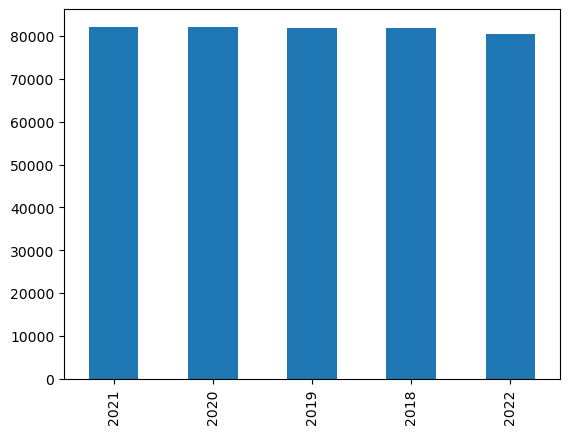

In [69]:
#Bar Graph Years
clean_df['Year'].value_counts().plot(kind = 'bar')

In [70]:
labels = [ "2018", "2019", "2020","2021","2022"]
sizes = [ 81792, 81956, 82072, 82192, 80600]
colors = ["pink","yellowgreen","lightskyblue","lightcoral"]
explode = (0.1,0,0,0,0)

#Year
#2021    82192
#2020    82072
#2019    81956
#2018    81792
#2015    81444
#2016    81360
#2014    81252
#2017    81252
#2012    81068
#2013    80628
#2022    80600

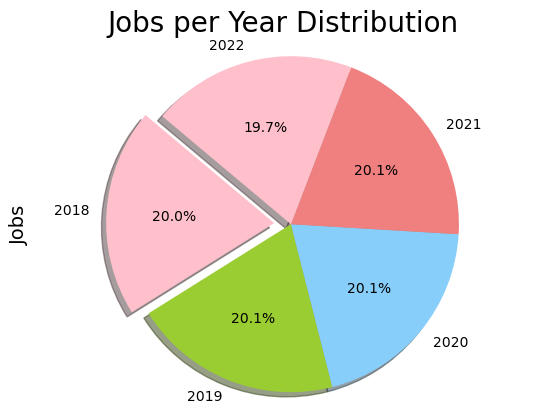

In [71]:
#Tell matplotlib to create a pie chart based upon the above data
plt.pie(sizes, explode=explode,labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140,)
plt.axis("equal")
plt.title("Jobs per Year Distribution", fontsize = 20)
plt.ylabel('Jobs', fontsize = 14)
plt.show()

In [72]:
#Correlation Matrix among numerical features:
corr_wages = clean_df[['Year','Avg_Wk_Wage','Total_Quart_Wages','Mon1_Employ', 'Mon2_Employ', 'Mon3_Employ']].corr()
corr_wages

,Year,Avg_Wk_Wage,Total_Quart_Wages,Mon1_Employ,Mon2_Employ,Mon3_Employ
Year,1.000000,0.057322,0.003975,-0.000989,-0.000939,-0.000856
Avg_Wk_Wage,0.057322,1.000000,0.111817,0.067695,0.067581,0.067475
Total_Quart_Wages,0.003975,0.111817,1.000000,0.903150,0.903292,0.902630
Mon1_Employ,-0.000989,0.067695,0.903150,1.000000,0.999963,0.999855
Mon2_Employ,-0.000939,0.067581,0.903292,0.999963,1.000000,0.999914
Mon3_Employ,-0.000856,0.067475,0.902630,0.999855,0.999914,1.000000


In [73]:
#Check how many counties
clean_df['County'].value_counts()

New York County, New York        40524
Kings County, New York           40344
Fairfield County, Connecticut    40276
Bergen County, New Jersey        40100
Nassau County, New York          40092
Westchester County, New York     38296
Queens County, New York          38260
Hudson County, New Jersey        36296
Bronx County, New York           32692
Rockland County, New York        32004
Richmond County, New York        29728
Name: County, dtype: int64

<Axes: >

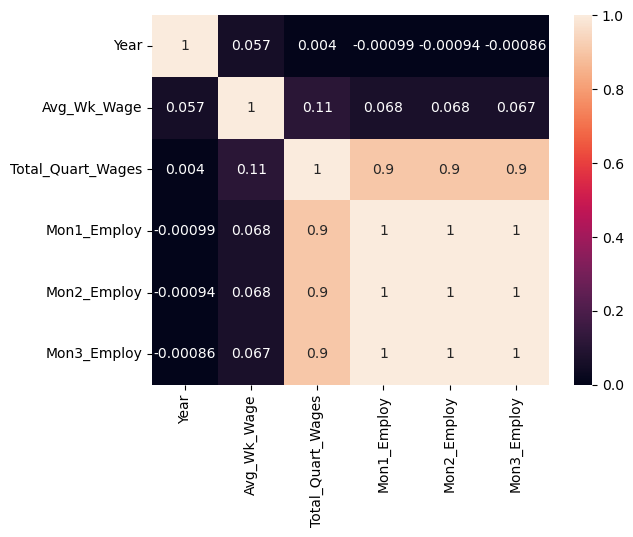

In [74]:
#Heatmap between year, avg wage and tot quart wages, over-the-year change in employment level for the first,second, and third months
sns.heatmap(corr_wages, annot = True)

<Axes: >

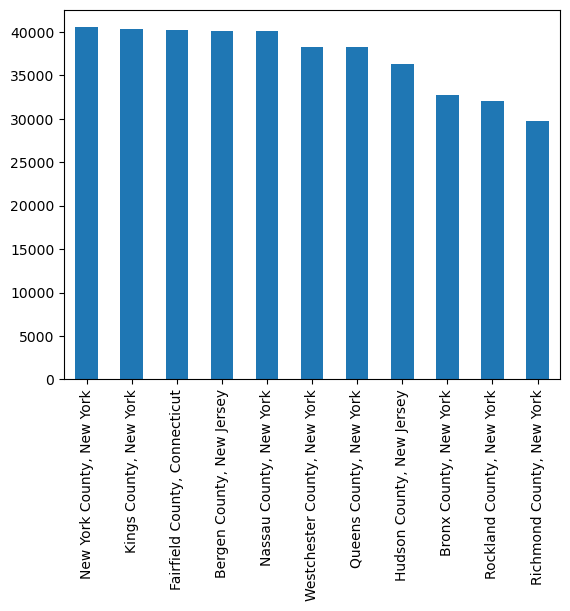

In [75]:
#Bar graph of employment records per county
clean_df['County'].value_counts().plot(kind = 'bar')

In [76]:
labels = ["Fairfield", "New_York", "Nassau", "Bergen", "Kings", "Westchester", "Queens", "Hudson", "Bronx","Rockland","Richmond"]
sizes = [89260, 89260, 89260, 88840, 87060, 84608, 83292, 79708, 71148, 70064, 63468]
colors = ["yellow","green","lightblue","orange","red","purple","pink","yellowgreen","lightskyblue","lightcoral"]
explode = (0.1,0,0,0,0,0,0,0,0,0,0)

#County
#Fairfield County, Connecticut    89260
#New York County, New York        89260
#Nassau County, New York          89260
#Bergen County, New Jersey        88840
#Kings County, New York           87060
#Westchester County, New York     84608
#Queens County, New York          83292
#Hudson County, New Jersey        79708
#Bronx County, New York           71148
#Rockland County, New York        70064
#Richmond County, New York        63468

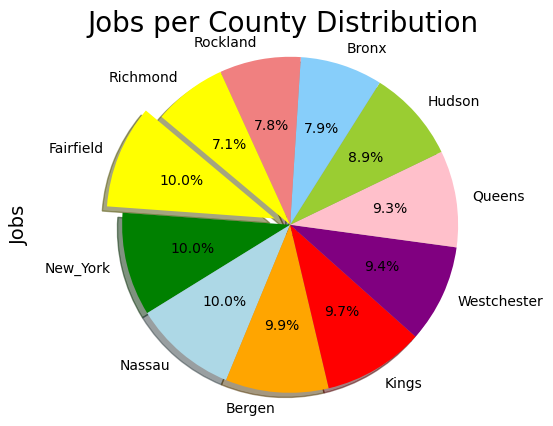

In [77]:
# Tell matplotlib to create a pie chart based upon the above data
plt.pie(sizes, explode=explode,labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140,)
plt.axis("equal")
plt.title("Jobs per County Distribution", fontsize = 20)
plt.ylabel('Jobs', fontsize = 14)
plt.show()

In [78]:
#Check how many quarters ##Data Cleaning
clean_df['Quarter'].value_counts()

1    102153
2    102153
3    102153
4    102153
Name: Quarter, dtype: int64

<Axes: >

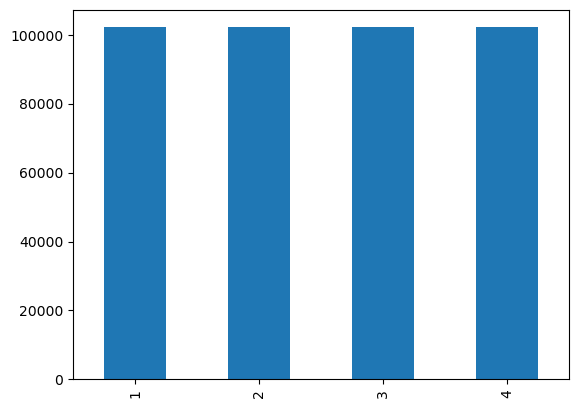

In [79]:
#Bar Graph Quarters
clean_df['Quarter'].value_counts().plot(kind = 'bar')

In [80]:
#Check how many area fips: Federal info  Processing Standards code for the area
clean_df['Area_Fips'].value_counts()

36061    40524
36047    40344
9001     40276
34003    40100
36059    40092
36119    38296
36081    38260
34017    36296
36005    32692
36087    32004
36085    29728
Name: Area_Fips, dtype: int64

<Axes: >

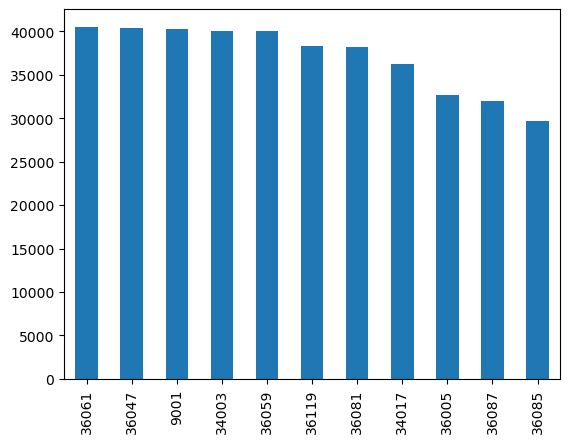

In [81]:
#Bar Graph by Area_Fips aka County Code 9001 Fairfield (CT), 36061 NY (NY), 36059 Nassau (NY), 34003 Bergen (NJ),36047 Kings (NY)
#County Codes cont.: 36119 Westchester (NY), 36081 Queens (NY), 34017 Hudson (NJ), 36005 Bronx (NY),36087 Rockland (NY), 36085 Richmond (NY)
clean_df['Area_Fips'].value_counts().plot(kind = 'bar')

<Axes: ylabel='Frequency'>

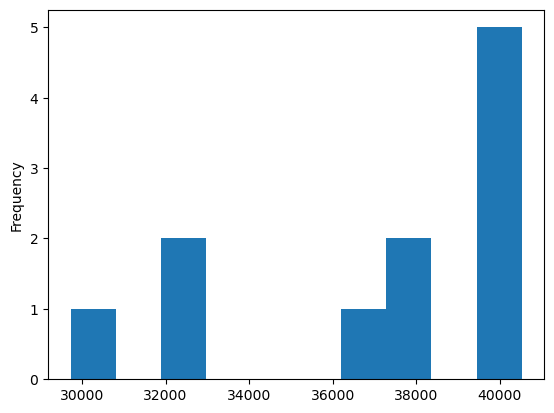

In [82]:
#Histogram based on area_fips aka County Code 9001 Fairfield (CT), 36061 NY (NY), 36059 Nassau (NY), 34003 Bergen (NJ),36047 Kings (NY)
#County Codes cont.: 36119 Westchester (NY), 36081 Queens (NY), 34017 Hudson (NJ), 36005 Bronx (NY),36087 Rockland (NY), 36085 Richmond (NY)
clean_df['Area_Fips'].value_counts().plot(kind = 'hist')

In [83]:
#Correlation Matrix among numerical features. Area_Fips are the county codes.
corr_county_wages = clean_df[['Area_Fips','Avg_Wk_Wage','Total_Quart_Wages','Mon1_Employ', 'Mon2_Employ', 'Mon3_Employ']].corr()
corr_county_wages

,Area_Fips,Avg_Wk_Wage,Total_Quart_Wages,Mon1_Employ,Mon2_Employ,Mon3_Employ
Area_Fips,1.000000,-0.059840,0.008638,0.011942,0.011988,0.011985
Avg_Wk_Wage,-0.059840,1.000000,0.111817,0.067695,0.067581,0.067475
Total_Quart_Wages,0.008638,0.111817,1.000000,0.903150,0.903292,0.902630
Mon1_Employ,0.011942,0.067695,0.903150,1.000000,0.999963,0.999855
Mon2_Employ,0.011988,0.067581,0.903292,0.999963,1.000000,0.999914
Mon3_Employ,0.011985,0.067475,0.902630,0.999855,0.999914,1.000000


<Axes: >

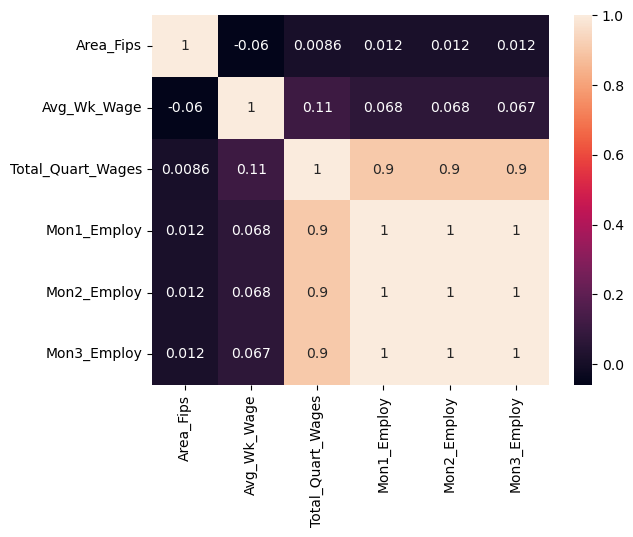

In [84]:
#Heatmap between area fips, avg wage and tot quart wages, over-the-year change in employment level for the first,second, and third months
sns.heatmap(corr_county_wages, annot = True)

In [85]:
#Check how many average weekly wages #Avg_Wk_Wage
clean_df['Avg_Wk_Wage'].value_counts()

0       146324
660        222
1054       221
682        218
824        217
         ...  
7508         1
5471         1
4541         1
5131         1
4223         1
Name: Avg_Wk_Wage, Length: 6111, dtype: int64

In [86]:
#"Check how many Industry_Codes
clean_df['Industry_Code'].value_counts()

10        1100
102        880
62         820
1025       820
1021       716
          ... 
33637        4
336370       4
1133         4
11331        4
321215       4
Name: Industry_Code, Length: 2326, dtype: int64

<Axes: ylabel='Frequency'>

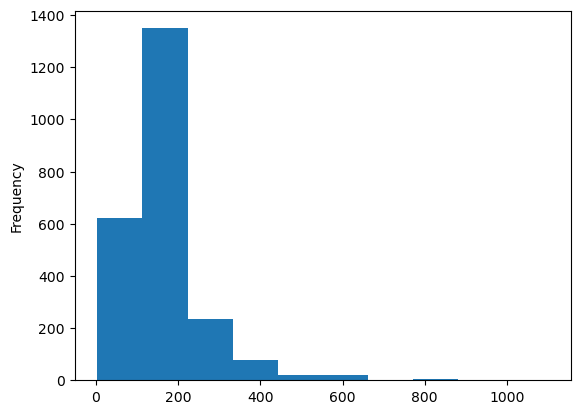

In [87]:
#Histogram Industry Code 
clean_df['Industry_Code'].value_counts().plot(kind = 'hist')

In [88]:
#Check how many Industry_Titles
clean_df['Industry_Title'].value_counts()

10 Total, all industries                                                   1100
102 Service-providing                                                       880
NAICS 62 Health care and social assistance                                  820
1025 Education and health services                                          820
1021 Trade, transportation, and utilities                                   716
                                                                           ... 
NAICS 32522 Artificial and synthetic fibers and filaments manufacturing       4
NAICS 11132 Citrus (except orange) groves                                     4
NAICS 111320 Citrus (except orange) groves                                    4
NAICS 212313 Crushed and broken granite mining and quarrying                  4
NAICS 11331 Logging                                                           4
Name: Industry_Title, Length: 2902, dtype: int64

<Axes: ylabel='Frequency'>

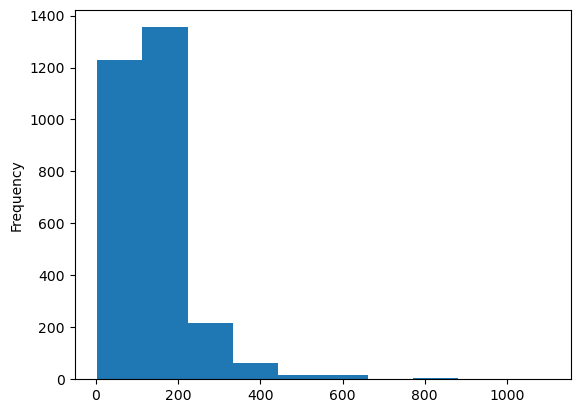

In [89]:
#Histogram Industry Title
clean_df['Industry_Title'].value_counts().plot(kind = 'hist')

In [90]:
labels = ["10 Total, all industries", "102 Service-providing", "Postal service", "NAICS 62 Health care and social assistance", "#1025 Education and health services"]
sizes = [1540, 1232, 1184, 1148, 1148]
colors = ["yellow","green","lightblue","orange","red"]
explode = (0.1,0,0,0,0)

#Industry_Title
#10 Total, all industries                                               1540
#102 Service-providing                                                  1232
#Postal service                                                         1184
#NAICS 62 Health care and social assistance                             1148
#1025 Education and health services                                     1148

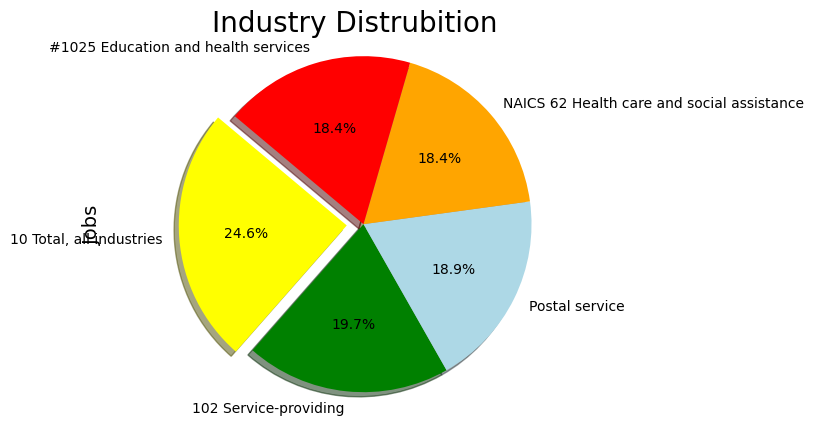

In [91]:
# Tell matplotlib to create a pie chart based upon the above data
plt.pie(sizes, explode=explode,labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140,)
plt.axis("equal")
plt.title("Industry Distrubition", fontsize = 20)
plt.ylabel('Jobs', fontsize = 14)
plt.show()

In [92]:
#Check how many over the year average weekly wage change percentage #Endyr_Avg_Wk_WagePct
clean_df['Endyr_Avg_Wk_WagePct'].value_counts()

KeyError: 'Endyr_Avg_Wk_WagePct'

In [94]:
#Check how many over the year average weekly wage change #Endyr_Avg_Wk_Wage
clean_df['Endyr_Avg_Wk_Wage_Chg'].value_counts()

KeyError: 'Endyr_Avg_Wk_Wage_Chg'

In [95]:
#Check how many over the year average weekly wage change percentage Endyr_Avg_Wk_WagePctChg
clean_df['Endyr_Avg_Wk_WagePctChg'].value_counts()

KeyError: 'Endyr_Avg_Wk_WagePctChg'

/var/folders/xn/flzj9nh10rn23jrk_xt8vpb40000gn/T/ipykernel_99423/420037729.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 16, color='black')


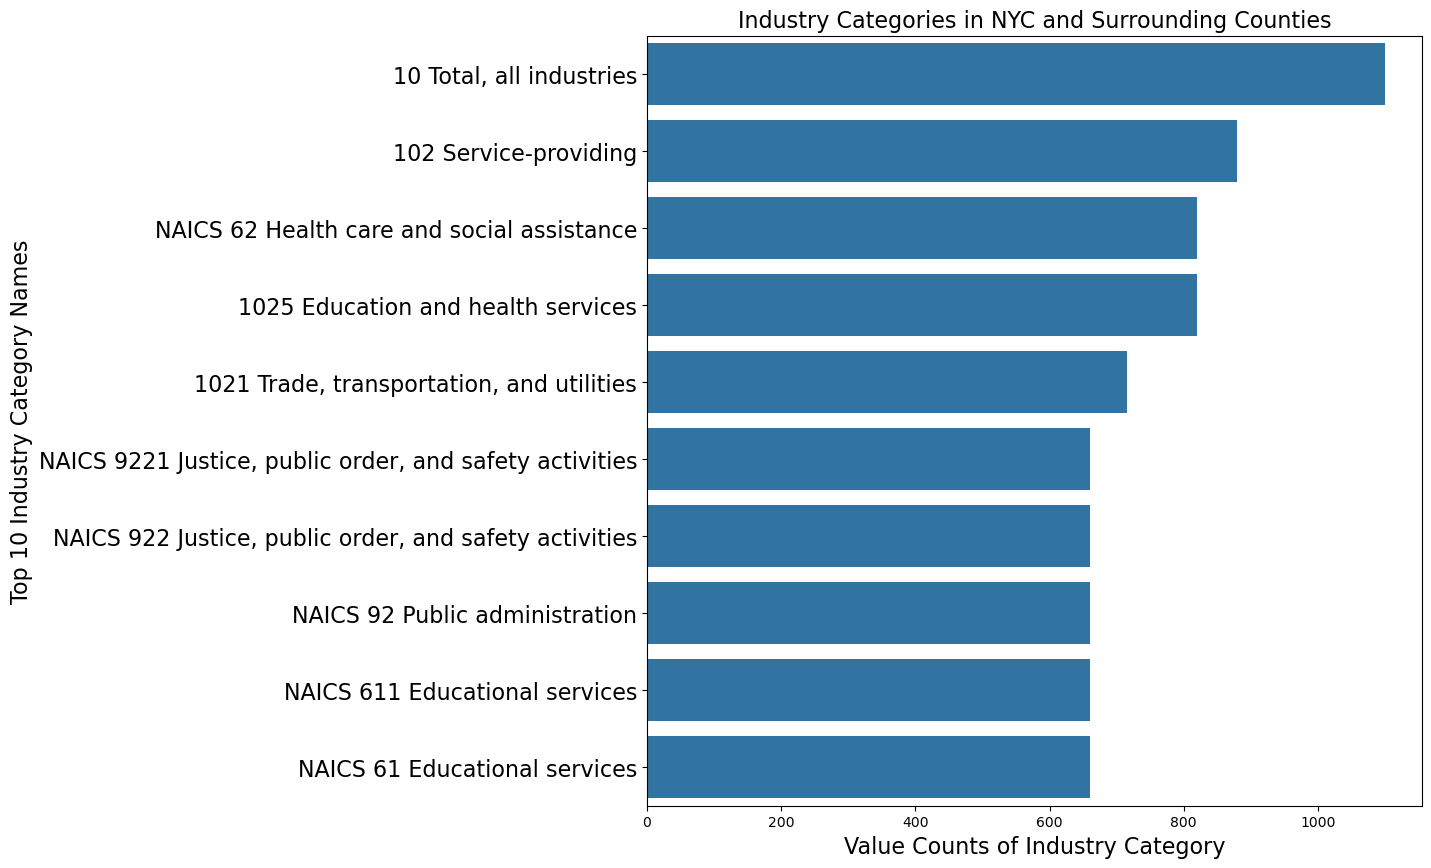

In [96]:
# Industry Titles #Careers
 
Industry_Catergory_df = clean_df['Industry_Title'].value_counts()[:10]
plt.figure(figsize=(10,10))
res=sns.barplot(x=Industry_Catergory_df, y=Industry_Catergory_df.index)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 16, color='black')
plt.xlabel('Value Counts of Industry Category',fontsize = 16, color='black')
plt.ylabel('Top 10 Industry Category Names',fontsize = 16, color='black')
plt.title('Industry Categories in NYC and Surrounding Counties',fontsize = 16, color='black')
plt.show()

/var/folders/xn/flzj9nh10rn23jrk_xt8vpb40000gn/T/ipykernel_99423/2798841013.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 16, color='black')


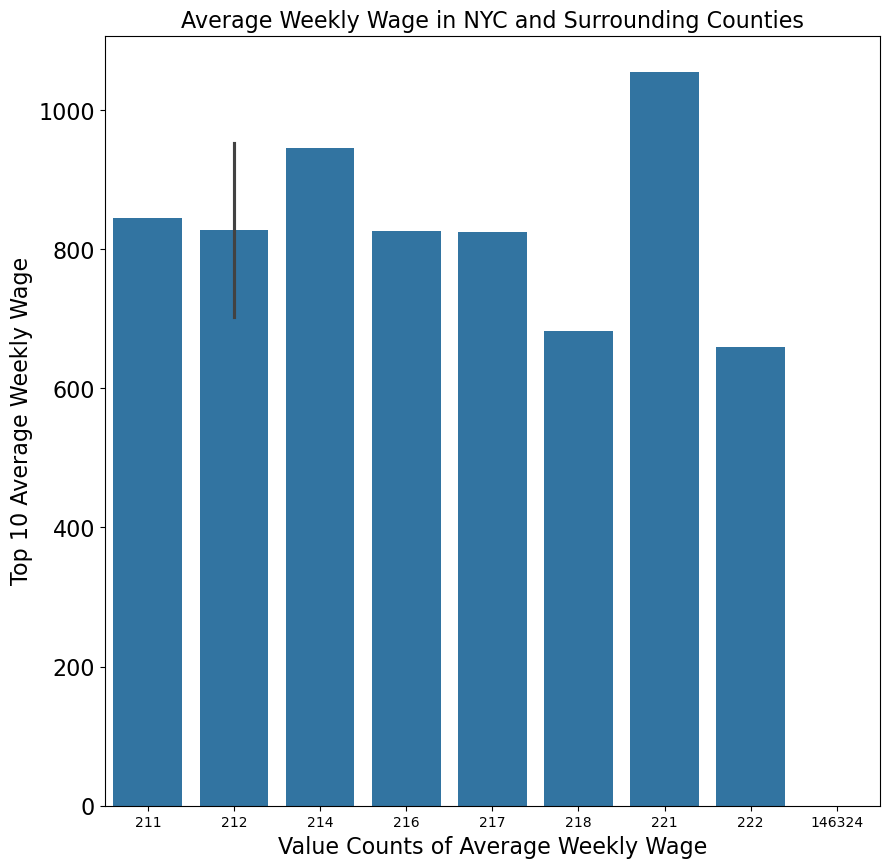

In [97]:
# Average Weekly Wages
 
Avg_Wk_Wage_df = clean_df['Avg_Wk_Wage'].value_counts()[:10]
plt.figure(figsize=(10,10))
res=sns.barplot(x=Avg_Wk_Wage_df, y=Avg_Wk_Wage_df.index)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 16, color='black')
plt.xlabel('Value Counts of Average Weekly Wage',fontsize = 16, color='black')
plt.ylabel('Top 10 Average Weekly Wage',fontsize = 16, color='black')
plt.title('Average Weekly Wage in NYC and Surrounding Counties',fontsize = 16, color='black')
plt.show()

In [98]:
labels = ["640", "813", "660", "724"]
sizes =  [483, 474,471,471]
colors = ["yellow","green","lightblue","orange"]
explode = (0.1,0,0,0,)

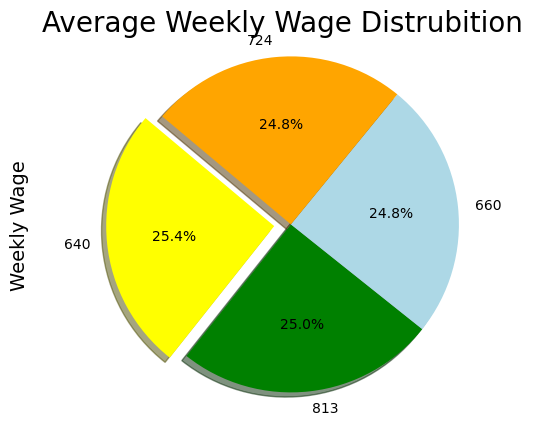

In [99]:
plt.pie(sizes, explode=explode,labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140,)
plt.axis("equal")
plt.title("Average Weekly Wage Distrubition", fontsize = 20)
plt.ylabel('Weekly Wage', fontsize = 14)
plt.show()

#Avg_Wk_Wage
#0        323373
#640         483
#813         474
#660         471
#724         471

In [100]:
#Seeing if by the end of the year, what the average weekly percentages were

labels = ["2.0", "1.4", "0.8", "1.3"]
sizes =  [1263, 1226, 1221, 1221]
colors = ["yellow","green","lightblue","orange"]
explode = (0.1,0,0,0)

#Endyr_Avg_Wk_WagePct
#0.0      129156
#2.0        1263
#1.4        1226
#0.8        1221
#1.3        1221

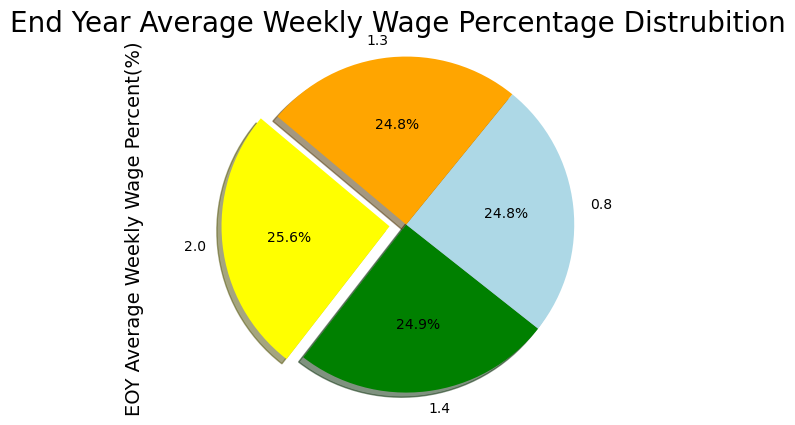

In [101]:
plt.pie(sizes, explode=explode,labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140,)
plt.axis("equal")
plt.title("End Year Average Weekly Wage Percentage Distrubition", fontsize = 20)
plt.ylabel('EOY Average Weekly Wage Percent(%) ', fontsize = 14)
plt.show()

In [102]:
#Attempting to make a bubble chart
#Bonus Challenge
#clean_df['Avg_Wk_Wage'] = round(clean_df['Avg_Wk_Wage'])
#clean_df['Year'] = clean_df['Year'].astype('int')

#clean_df['Endyr_Avg_Wk_Wage_Chg'] = round(clean_df['Endyr_Avg_Wk_Wage_Chg'])
#clean_df['Year'] = clean_df['Year'].astype('int')


#fig = bubbleplot(clean_df, x_column='Loc_Mon1_Employ', y_column='year', bubble_column='Industry_Code', size_column='Size_Title', x_title='Av_Wage', color_column='Industry_Code', 
                 #y_title='Endyg', title='Career per Average Weekly Wage', x_logscale=False, scale_bubble=3, height=650)

#py.iplot(fig)
#Reference for trying to make bubble chart https://www.youtube.com/watch?v=Uu2mfzWajQY
#https://www.youtube.com/watch?v=D2THI97PHHU
#https://www.kaggle.com/code/rajwardhanshinde/can-you-get-a-job-in-ny

In [103]:
#d = {
    #'potato': 'tomato',
    #'pi': 3.14159,
    #'#name': 'Carlos',
#}
#d2 = dict(
    #potato='tomato',
    #3pi=3.14159,
    #name='Carlos',
#)
#class A:
    #def __init__(self, , **kwargs):
        #for param, arg in kwargs.items():
            #setattr(self, param, arg)
    #def __str__(self):
        #return f"str version: {self.__class__.__name__}" \
            #f"({",".join(f"{param}={arg}" for param, arg in sorted(self.__dict__.items()))})"
    #def __repr__(self):
        #return f"repr version: {self.__class__.__name__}" \
            #f"({','.join(f'{param}={arg!r}' for param, arg in sorted(self.__dict__.items()))})"

#a = A(potato='tomato', pi=3.1415926, name='Carlos', none=None)
#print(f"default: {a}")
#print(f"with_bang_s: {a!s}")
#print(f"with_bang_r: {a!r}")

In [105]:
#Reference NYC Housing Data

#Kaggle Datasets
#https://www.kaggle.com/code/shaqiavelli/nyc-geospatial-analysis
#https://www.kaggle.com/code/ashokmevada/house-price

#NYC Planning #????
#https://www.nyc.gov/site/planning/data-maps/open-data/dwn-housing-database.page#housingdevelopmentproject

#NYC.GOV Annual Housing Sales 2012-2022
#https://www.nyc.gov/site/finance/property/property-annualized-sales-update.page

#Reference Bureau of Labor Statistics (bls) API_Key Multiple Series and csv files

##bls.gov: https://www.bls.gov/developers/api_signature_v2.htm (API_Key)
##https://www.bls.gov/cew/downloadable-data-files.htm (csv files)
##https://www.bls.gov/cew/additional-resources/open-data/sample-code.htm (sample python code)